# EuroSAT Dataset Applying Custom CNN 

In [35]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [36]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [37]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [38]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: SeaLake --> count: 3000
class: HerbaceousVegetation --> count: 3000
class: Forest --> count: 3000
class: AnnualCrop --> count: 3000
class: Residential --> count: 3000
class: Highway --> count: 2500
class: Industrial --> count: 2500
class: PermanentCrop --> count: 2500
class: River --> count: 2500
class: Pasture --> count: 2000


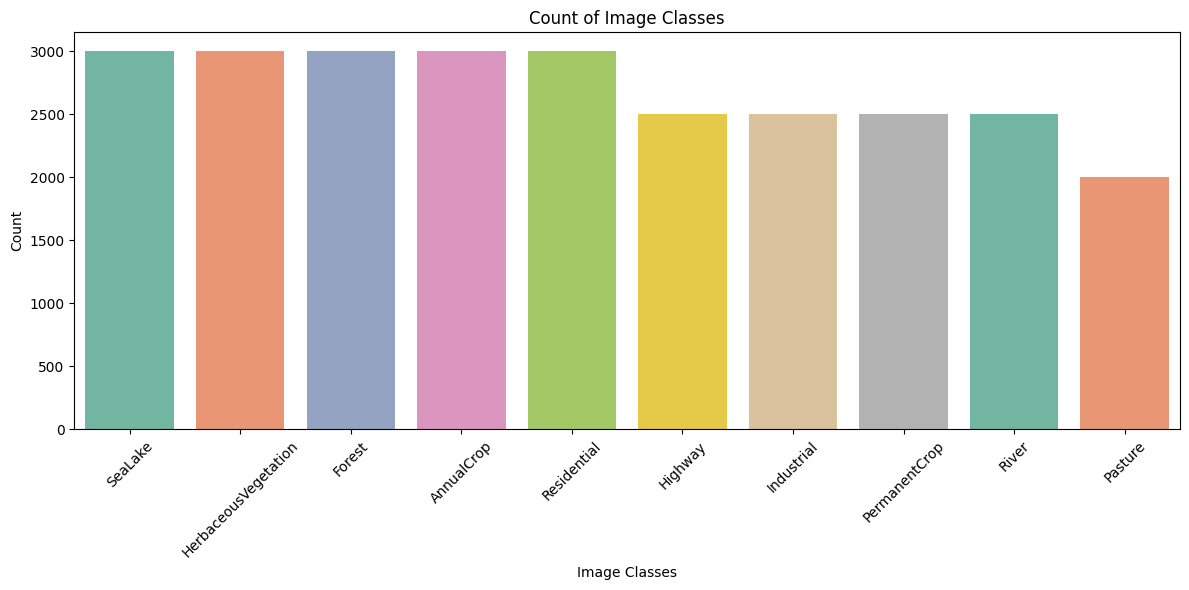

In [39]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

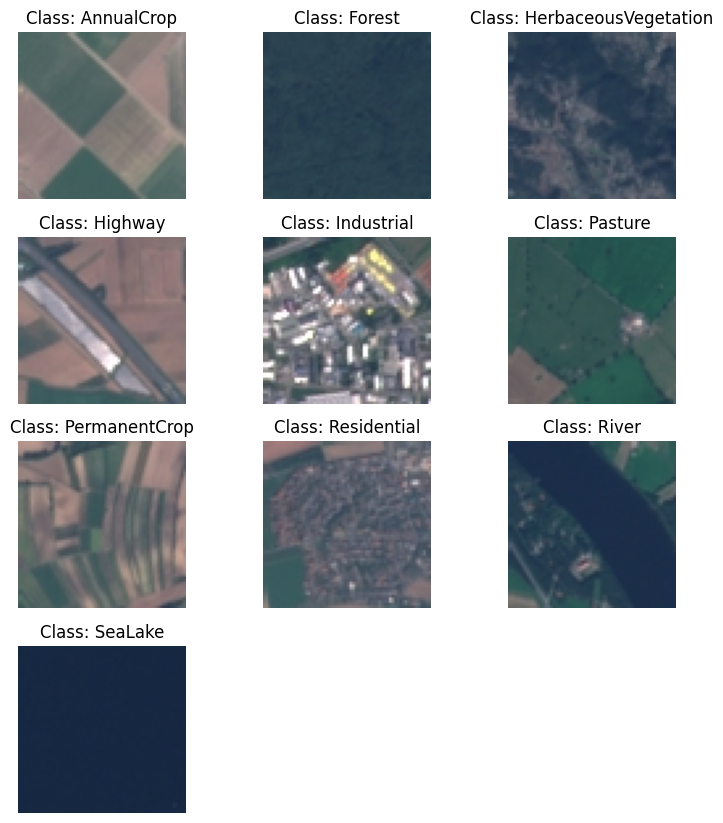

In [40]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [41]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [42]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [43]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [44]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [46]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [47]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [48]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [49]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Convolutional Neural Netwirk (G7CNN)

In [50]:
class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, 5, padding=2),  # Output: 32x224x224
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 5, padding=2),  # Output: 32x224x224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 5, padding=2),  # 64x112x112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1),  # 128x56x56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, 3, padding=1),  # 256x28x28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(256, 512, 3, padding=1),  # 512x14x14
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 7x7
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1,1)) # 512x1x1

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


        

In [51]:
total_class = 10
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           1,216
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]          12,832
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          51,264
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

### Training

In [52]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=100, early_stop_patience=100, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/100: 100%|██████████| 296/296 [01:14<00:00,  3.98it/s, acc=0.607, loss=1.13]

Training Loss: 1.133 Acc: 0.607


Validation Loss: 0.822 Acc: 0.708
✅ Best model saved at epoch 1 with validation accuracy: 0.708


Epoch 2/100: 100%|██████████| 296/296 [00:45<00:00,  6.51it/s, acc=0.731, loss=0.782]

Training Loss: 0.782 Acc: 0.731


Validation Loss: 0.870 Acc: 0.680


Epoch 3/100: 100%|██████████| 296/296 [00:45<00:00,  6.51it/s, acc=0.779, loss=0.648]

Training Loss: 0.648 Acc: 0.779


Validation Loss: 0.469 Acc: 0.832
✅ Best model saved at epoch 3 with validation accuracy: 0.832


Epoch 4/100: 100%|██████████| 296/296 [00:44<00:00,  6.66it/s, acc=0.809, loss=0.553]

Training Loss: 0.553 Acc: 0.809


Validation Loss: 0.409 Acc: 0.859
✅ Best model saved at epoch 4 with validation accuracy: 0.859


Epoch 5/100: 100%|██████████| 296/296 [00:43<00:00,  6.75it/s, acc=0.834, loss=0.484]

Training Loss: 0.484 Acc: 0.834


Validation Loss: 0.632 Acc: 0.793


Epoch 6/100: 100%|██████████| 296/296 [00:44<00:00,  6.69it/s, acc=0.854, loss=0.437]

Training Loss: 0.437 Acc: 0.854


Validation Loss: 0.376 Acc: 0.868
✅ Best model saved at epoch 6 with validation accuracy: 0.868


Epoch 7/100: 100%|██████████| 296/296 [00:45<00:00,  6.55it/s, acc=0.863, loss=0.399]

Training Loss: 0.399 Acc: 0.863


Validation Loss: 0.367 Acc: 0.872
✅ Best model saved at epoch 7 with validation accuracy: 0.872


Epoch 8/100: 100%|██████████| 296/296 [00:44<00:00,  6.64it/s, acc=0.877, loss=0.366]

Training Loss: 0.366 Acc: 0.877


Validation Loss: 0.351 Acc: 0.875
✅ Best model saved at epoch 8 with validation accuracy: 0.875


Epoch 9/100: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.884, loss=0.343]

Training Loss: 0.343 Acc: 0.884


Validation Loss: 0.328 Acc: 0.883
✅ Best model saved at epoch 9 with validation accuracy: 0.883


Epoch 10/100: 100%|██████████| 296/296 [00:44<00:00,  6.61it/s, acc=0.893, loss=0.315]

Training Loss: 0.315 Acc: 0.893


Validation Loss: 0.244 Acc: 0.916
✅ Best model saved at epoch 10 with validation accuracy: 0.916


Epoch 11/100: 100%|██████████| 296/296 [00:43<00:00,  6.79it/s, acc=0.897, loss=0.302]

Training Loss: 0.302 Acc: 0.897


Validation Loss: 0.398 Acc: 0.866


Epoch 12/100: 100%|██████████| 296/296 [00:44<00:00,  6.63it/s, acc=0.902, loss=0.286]

Training Loss: 0.286 Acc: 0.902


Validation Loss: 0.327 Acc: 0.883


Epoch 13/100: 100%|██████████| 296/296 [00:44<00:00,  6.63it/s, acc=0.909, loss=0.266]

Training Loss: 0.266 Acc: 0.909


Validation Loss: 0.334 Acc: 0.884


Epoch 14/100: 100%|██████████| 296/296 [00:44<00:00,  6.72it/s, acc=0.91, loss=0.263] 

Training Loss: 0.263 Acc: 0.910


Validation Loss: 0.222 Acc: 0.923
✅ Best model saved at epoch 14 with validation accuracy: 0.923


Epoch 15/100: 100%|██████████| 296/296 [00:45<00:00,  6.46it/s, acc=0.917, loss=0.244]

Training Loss: 0.244 Acc: 0.917


Validation Loss: 0.195 Acc: 0.930
✅ Best model saved at epoch 15 with validation accuracy: 0.930


Epoch 16/100: 100%|██████████| 296/296 [00:45<00:00,  6.52it/s, acc=0.917, loss=0.237]

Training Loss: 0.237 Acc: 0.917


Validation Loss: 0.242 Acc: 0.915


Epoch 17/100: 100%|██████████| 296/296 [00:46<00:00,  6.38it/s, acc=0.918, loss=0.235]

Training Loss: 0.235 Acc: 0.918


Validation Loss: 0.211 Acc: 0.927


Epoch 18/100: 100%|██████████| 296/296 [00:43<00:00,  6.82it/s, acc=0.923, loss=0.222]

Training Loss: 0.222 Acc: 0.923


Validation Loss: 0.236 Acc: 0.914


Epoch 19/100: 100%|██████████| 296/296 [00:44<00:00,  6.71it/s, acc=0.927, loss=0.208]

Training Loss: 0.208 Acc: 0.927


Validation Loss: 0.216 Acc: 0.926


Epoch 20/100: 100%|██████████| 296/296 [00:46<00:00,  6.38it/s, acc=0.93, loss=0.202] 

Training Loss: 0.202 Acc: 0.930


Validation Loss: 0.160 Acc: 0.944
✅ Best model saved at epoch 20 with validation accuracy: 0.944


Epoch 21/100: 100%|██████████| 296/296 [00:46<00:00,  6.42it/s, acc=0.936, loss=0.19] 

Training Loss: 0.190 Acc: 0.936


Validation Loss: 0.190 Acc: 0.927


Epoch 22/100: 100%|██████████| 296/296 [00:45<00:00,  6.51it/s, acc=0.934, loss=0.191]

Training Loss: 0.191 Acc: 0.934


Validation Loss: 0.150 Acc: 0.949
✅ Best model saved at epoch 22 with validation accuracy: 0.949


Epoch 23/100: 100%|██████████| 296/296 [00:44<00:00,  6.70it/s, acc=0.936, loss=0.187]

Training Loss: 0.187 Acc: 0.936


Validation Loss: 0.215 Acc: 0.922


Epoch 24/100: 100%|██████████| 296/296 [00:45<00:00,  6.55it/s, acc=0.939, loss=0.179]

Training Loss: 0.179 Acc: 0.939


Validation Loss: 0.172 Acc: 0.935


Epoch 25/100: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.941, loss=0.169]

Training Loss: 0.169 Acc: 0.941


Validation Loss: 0.164 Acc: 0.947


Epoch 26/100: 100%|██████████| 296/296 [00:51<00:00,  5.79it/s, acc=0.941, loss=0.169]

Training Loss: 0.169 Acc: 0.941


Validation Loss: 0.165 Acc: 0.945


Epoch 27/100: 100%|██████████| 296/296 [00:46<00:00,  6.30it/s, acc=0.94, loss=0.171] 

Training Loss: 0.171 Acc: 0.940


Validation Loss: 0.149 Acc: 0.951
✅ Best model saved at epoch 27 with validation accuracy: 0.951


Epoch 28/100: 100%|██████████| 296/296 [00:43<00:00,  6.77it/s, acc=0.944, loss=0.164]

Training Loss: 0.164 Acc: 0.944


Validation Loss: 0.125 Acc: 0.960
✅ Best model saved at epoch 28 with validation accuracy: 0.960


Epoch 31/100: 100%|██████████| 296/296 [00:45<00:00,  6.53it/s, acc=0.95, loss=0.146] 

Training Loss: 0.146 Acc: 0.950


Validation Loss: 0.157 Acc: 0.952


Epoch 32/100: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.949, loss=0.145]

Training Loss: 0.145 Acc: 0.949


Validation Loss: 0.233 Acc: 0.920


Epoch 33/100: 100%|██████████| 296/296 [00:43<00:00,  6.73it/s, acc=0.951, loss=0.14] 

Training Loss: 0.140 Acc: 0.951


Validation Loss: 0.159 Acc: 0.951


Epoch 34/100: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.953, loss=0.136]

Training Loss: 0.136 Acc: 0.953


Validation Loss: 0.132 Acc: 0.957


Epoch 35/100: 100%|██████████| 296/296 [00:44<00:00,  6.65it/s, acc=0.953, loss=0.135]

Training Loss: 0.135 Acc: 0.953


Validation Loss: 0.143 Acc: 0.950


Epoch 36/100: 100%|██████████| 296/296 [00:45<00:00,  6.46it/s, acc=0.953, loss=0.13] 

Training Loss: 0.130 Acc: 0.953


Validation Loss: 0.121 Acc: 0.957


Epoch 37/100: 100%|██████████| 296/296 [00:45<00:00,  6.55it/s, acc=0.957, loss=0.128]

Training Loss: 0.128 Acc: 0.957


Validation Loss: 0.164 Acc: 0.946


Epoch 38/100: 100%|██████████| 296/296 [00:45<00:00,  6.54it/s, acc=0.954, loss=0.125]

Training Loss: 0.125 Acc: 0.954


Validation Loss: 0.161 Acc: 0.946


Epoch 39/100: 100%|██████████| 296/296 [00:44<00:00,  6.63it/s, acc=0.955, loss=0.126]

Training Loss: 0.126 Acc: 0.955


Validation Loss: 0.123 Acc: 0.959


Epoch 40/100: 100%|██████████| 296/296 [00:46<00:00,  6.34it/s, acc=0.957, loss=0.121]

Training Loss: 0.121 Acc: 0.957


Validation Loss: 0.184 Acc: 0.938


Epoch 41/100: 100%|██████████| 296/296 [00:46<00:00,  6.35it/s, acc=0.958, loss=0.12] 

Training Loss: 0.120 Acc: 0.958


Validation Loss: 0.122 Acc: 0.962
✅ Best model saved at epoch 41 with validation accuracy: 0.962


Epoch 42/100: 100%|██████████| 296/296 [00:43<00:00,  6.83it/s, acc=0.959, loss=0.119]

Training Loss: 0.119 Acc: 0.959


Validation Loss: 0.140 Acc: 0.954


Epoch 43/100: 100%|██████████| 296/296 [00:43<00:00,  6.83it/s, acc=0.959, loss=0.118]

Training Loss: 0.118 Acc: 0.959


Validation Loss: 0.111 Acc: 0.961


Epoch 44/100: 100%|██████████| 296/296 [00:45<00:00,  6.53it/s, acc=0.962, loss=0.108]

Training Loss: 0.108 Acc: 0.962


Validation Loss: 0.116 Acc: 0.964
✅ Best model saved at epoch 44 with validation accuracy: 0.964


Epoch 45/100: 100%|██████████| 296/296 [00:46<00:00,  6.34it/s, acc=0.964, loss=0.105]

Training Loss: 0.105 Acc: 0.964


Validation Loss: 0.141 Acc: 0.953


Epoch 46/100: 100%|██████████| 296/296 [00:45<00:00,  6.52it/s, acc=0.958, loss=0.115]

Training Loss: 0.115 Acc: 0.958


Validation Loss: 0.141 Acc: 0.953


Epoch 47/100: 100%|██████████| 296/296 [00:45<00:00,  6.44it/s, acc=0.963, loss=0.106]

Training Loss: 0.106 Acc: 0.963


Validation Loss: 0.134 Acc: 0.959


Epoch 48/100: 100%|██████████| 296/296 [00:45<00:00,  6.55it/s, acc=0.962, loss=0.107]

Training Loss: 0.107 Acc: 0.962


Validation Loss: 0.127 Acc: 0.958


Epoch 49/100: 100%|██████████| 296/296 [00:44<00:00,  6.59it/s, acc=0.966, loss=0.104]

Training Loss: 0.104 Acc: 0.966


Validation Loss: 0.144 Acc: 0.953


Epoch 50/100: 100%|██████████| 296/296 [00:44<00:00,  6.66it/s, acc=0.966, loss=0.0996]

Training Loss: 0.100 Acc: 0.966


Validation Loss: 0.151 Acc: 0.953


Epoch 51/100: 100%|██████████| 296/296 [00:44<00:00,  6.71it/s, acc=0.963, loss=0.104]

Training Loss: 0.104 Acc: 0.963


Validation Loss: 0.141 Acc: 0.954


Epoch 52/100: 100%|██████████| 296/296 [00:45<00:00,  6.53it/s, acc=0.965, loss=0.102] 

Training Loss: 0.102 Acc: 0.965


Validation Loss: 0.141 Acc: 0.953


Epoch 53/100: 100%|██████████| 296/296 [00:45<00:00,  6.44it/s, acc=0.968, loss=0.0914]

Training Loss: 0.091 Acc: 0.968


Validation Loss: 0.131 Acc: 0.959


Epoch 54/100: 100%|██████████| 296/296 [00:45<00:00,  6.57it/s, acc=0.966, loss=0.0994]

Training Loss: 0.099 Acc: 0.966


Validation Loss: 0.190 Acc: 0.938


Epoch 55/100: 100%|██████████| 296/296 [00:46<00:00,  6.40it/s, acc=0.967, loss=0.0945]

Training Loss: 0.095 Acc: 0.967


Validation Loss: 0.120 Acc: 0.962


Epoch 56/100: 100%|██████████| 296/296 [00:45<00:00,  6.50it/s, acc=0.968, loss=0.0868]

Training Loss: 0.087 Acc: 0.968


Validation Loss: 0.143 Acc: 0.952


Epoch 57/100: 100%|██████████| 296/296 [00:45<00:00,  6.55it/s, acc=0.969, loss=0.0885]

Training Loss: 0.088 Acc: 0.969


Validation Loss: 0.135 Acc: 0.957


Epoch 58/100: 100%|██████████| 296/296 [00:46<00:00,  6.36it/s, acc=0.97, loss=0.0849] 

Training Loss: 0.085 Acc: 0.970


Validation Loss: 0.130 Acc: 0.959


Epoch 59/100: 100%|██████████| 296/296 [00:45<00:00,  6.50it/s, acc=0.969, loss=0.0864]

Training Loss: 0.086 Acc: 0.969


Validation Loss: 0.105 Acc: 0.965
✅ Best model saved at epoch 59 with validation accuracy: 0.965


Epoch 60/100: 100%|██████████| 296/296 [00:42<00:00,  7.04it/s, acc=0.97, loss=0.086]  

Training Loss: 0.086 Acc: 0.970


Validation Loss: 0.143 Acc: 0.956


Epoch 61/100: 100%|██████████| 296/296 [00:45<00:00,  6.54it/s, acc=0.971, loss=0.0835]

Training Loss: 0.083 Acc: 0.971


Validation Loss: 0.121 Acc: 0.965


Epoch 62/100: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.97, loss=0.0861] 

Training Loss: 0.086 Acc: 0.970


Validation Loss: 0.106 Acc: 0.967
✅ Best model saved at epoch 62 with validation accuracy: 0.967


Epoch 63/100: 100%|██████████| 296/296 [00:43<00:00,  6.88it/s, acc=0.973, loss=0.0829]

Training Loss: 0.083 Acc: 0.973


Validation Loss: 0.133 Acc: 0.957


Epoch 64/100: 100%|██████████| 296/296 [00:45<00:00,  6.53it/s, acc=0.972, loss=0.0783]

Training Loss: 0.078 Acc: 0.972


Validation Loss: 0.108 Acc: 0.967
✅ Best model saved at epoch 64 with validation accuracy: 0.967


Epoch 65/100: 100%|██████████| 296/296 [00:44<00:00,  6.58it/s, acc=0.971, loss=0.0821]

Training Loss: 0.082 Acc: 0.971


Validation Loss: 0.132 Acc: 0.960


Epoch 66/100: 100%|██████████| 296/296 [00:44<00:00,  6.63it/s, acc=0.973, loss=0.0779]

Training Loss: 0.078 Acc: 0.973


Validation Loss: 0.133 Acc: 0.960


Epoch 67/100: 100%|██████████| 296/296 [00:46<00:00,  6.35it/s, acc=0.973, loss=0.0792]

Training Loss: 0.079 Acc: 0.973


Validation Loss: 0.143 Acc: 0.954


Epoch 68/100: 100%|██████████| 296/296 [00:48<00:00,  6.05it/s, acc=0.974, loss=0.0729]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.120 Acc: 0.965


Epoch 69/100: 100%|██████████| 296/296 [00:48<00:00,  6.17it/s, acc=0.972, loss=0.0772]

Training Loss: 0.077 Acc: 0.972


Validation Loss: 0.280 Acc: 0.912


Epoch 70/100: 100%|██████████| 296/296 [00:44<00:00,  6.63it/s, acc=0.975, loss=0.0728]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.139 Acc: 0.956


Epoch 71/100: 100%|██████████| 296/296 [00:44<00:00,  6.71it/s, acc=0.973, loss=0.0751]

Training Loss: 0.075 Acc: 0.973


Validation Loss: 0.125 Acc: 0.963


Epoch 72/100: 100%|██████████| 296/296 [00:45<00:00,  6.45it/s, acc=0.976, loss=0.0685]

Training Loss: 0.069 Acc: 0.976


Validation Loss: 0.155 Acc: 0.955


Epoch 73/100: 100%|██████████| 296/296 [00:44<00:00,  6.65it/s, acc=0.976, loss=0.0721]

Training Loss: 0.072 Acc: 0.976


Validation Loss: 0.121 Acc: 0.964


Epoch 74/100: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.975, loss=0.071] 

Training Loss: 0.071 Acc: 0.975


Validation Loss: 0.095 Acc: 0.972
✅ Best model saved at epoch 74 with validation accuracy: 0.972


Epoch 75/100: 100%|██████████| 296/296 [00:45<00:00,  6.51it/s, acc=0.976, loss=0.0719]

Training Loss: 0.072 Acc: 0.976


Validation Loss: 0.123 Acc: 0.961


Epoch 76/100: 100%|██████████| 296/296 [00:48<00:00,  6.08it/s, acc=0.975, loss=0.0709]

Training Loss: 0.071 Acc: 0.975


Validation Loss: 0.146 Acc: 0.956


Epoch 77/100: 100%|██████████| 296/296 [00:43<00:00,  6.73it/s, acc=0.977, loss=0.0663]

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.219 Acc: 0.941


Epoch 78/100: 100%|██████████| 296/296 [00:45<00:00,  6.56it/s, acc=0.975, loss=0.0702]

Training Loss: 0.070 Acc: 0.975


Validation Loss: 0.113 Acc: 0.963


Epoch 79/100: 100%|██████████| 296/296 [00:45<00:00,  6.50it/s, acc=0.977, loss=0.0652]

Training Loss: 0.065 Acc: 0.977


Validation Loss: 0.115 Acc: 0.964


Epoch 80/100: 100%|██████████| 296/296 [00:43<00:00,  6.78it/s, acc=0.977, loss=0.0655]

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.106 Acc: 0.969


Epoch 81/100: 100%|██████████| 296/296 [00:46<00:00,  6.42it/s, acc=0.979, loss=0.0615]

Training Loss: 0.061 Acc: 0.979


Validation Loss: 0.159 Acc: 0.951


Epoch 82/100: 100%|██████████| 296/296 [00:50<00:00,  5.90it/s, acc=0.976, loss=0.0674]

Training Loss: 0.067 Acc: 0.976


Validation Loss: 0.148 Acc: 0.955


Epoch 83/100: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.98, loss=0.0565] 

Training Loss: 0.056 Acc: 0.980


Validation Loss: 0.117 Acc: 0.963


Epoch 84/100: 100%|██████████| 296/296 [00:49<00:00,  6.04it/s, acc=0.978, loss=0.0616]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.232 Acc: 0.933


Epoch 85/100: 100%|██████████| 296/296 [00:48<00:00,  6.11it/s, acc=0.977, loss=0.0636]


Training Loss: 0.064 Acc: 0.977
Validation Loss: 0.159 Acc: 0.954


Epoch 86/100: 100%|██████████| 296/296 [00:45<00:00,  6.47it/s, acc=0.98, loss=0.0599] 

Training Loss: 0.060 Acc: 0.980


Validation Loss: 0.132 Acc: 0.962


Epoch 87/100: 100%|██████████| 296/296 [00:45<00:00,  6.51it/s, acc=0.979, loss=0.0603]

Training Loss: 0.060 Acc: 0.979


Validation Loss: 0.136 Acc: 0.958


Epoch 88/100: 100%|██████████| 296/296 [00:46<00:00,  6.42it/s, acc=0.978, loss=0.0637]

Training Loss: 0.064 Acc: 0.978


Validation Loss: 0.092 Acc: 0.974
✅ Best model saved at epoch 88 with validation accuracy: 0.974


Epoch 89/100: 100%|██████████| 296/296 [00:45<00:00,  6.46it/s, acc=0.98, loss=0.0588] 

Training Loss: 0.059 Acc: 0.980


Validation Loss: 0.166 Acc: 0.948


Epoch 90/100: 100%|██████████| 296/296 [00:45<00:00,  6.57it/s, acc=0.981, loss=0.0554]

Training Loss: 0.055 Acc: 0.981


Validation Loss: 0.130 Acc: 0.961


Epoch 91/100: 100%|██████████| 296/296 [00:45<00:00,  6.56it/s, acc=0.979, loss=0.0564]

Training Loss: 0.056 Acc: 0.979


Validation Loss: 0.094 Acc: 0.972


Epoch 92/100: 100%|██████████| 296/296 [00:46<00:00,  6.35it/s, acc=0.98, loss=0.0571] 

Training Loss: 0.057 Acc: 0.980


Validation Loss: 0.112 Acc: 0.970


Epoch 93/100: 100%|██████████| 296/296 [00:45<00:00,  6.44it/s, acc=0.981, loss=0.0526]

Training Loss: 0.053 Acc: 0.981


Validation Loss: 0.106 Acc: 0.970


Epoch 94/100: 100%|██████████| 296/296 [00:48<00:00,  6.08it/s, acc=0.981, loss=0.0544]

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.118 Acc: 0.968


Epoch 95/100: 100%|██████████| 296/296 [00:48<00:00,  6.13it/s, acc=0.983, loss=0.0502]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.112 Acc: 0.968


Epoch 96/100: 100%|██████████| 296/296 [00:48<00:00,  6.10it/s, acc=0.981, loss=0.0562]

Training Loss: 0.056 Acc: 0.981


Validation Loss: 0.140 Acc: 0.960


Epoch 97/100: 100%|██████████| 296/296 [00:45<00:00,  6.49it/s, acc=0.979, loss=0.0561]

Training Loss: 0.056 Acc: 0.979


Validation Loss: 0.114 Acc: 0.970


Epoch 98/100: 100%|██████████| 296/296 [00:46<00:00,  6.39it/s, acc=0.983, loss=0.0493]

Training Loss: 0.049 Acc: 0.983


Validation Loss: 0.097 Acc: 0.973


Epoch 99/100: 100%|██████████| 296/296 [00:48<00:00,  6.04it/s, acc=0.981, loss=0.0535]

Training Loss: 0.053 Acc: 0.981


Validation Loss: 0.095 Acc: 0.970


Epoch 100/100: 100%|██████████| 296/296 [00:45<00:00,  6.53it/s, acc=0.98, loss=0.0575] 

Training Loss: 0.057 Acc: 0.980


Validation Loss: 0.102 Acc: 0.970
Training Time: 5111.93 seconds ---> 85.20 minutes


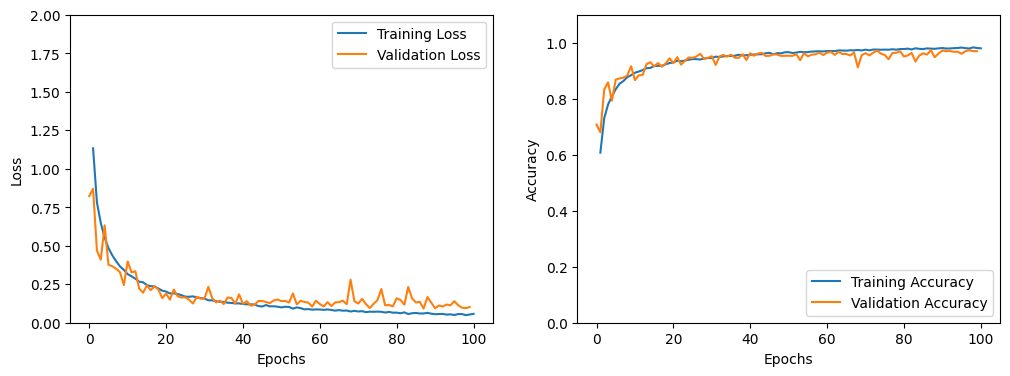

In [59]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [60]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 88) - Validation Loss: 0.095, Validation Accuracy: 0.973


In [61]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.971
Test Time: 5.52 seconds ---> 0.09 minutes


In [62]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       450
           1       0.99      0.98      0.99       450
           2       0.96      0.96      0.96       450
           3       0.99      0.97      0.98       375
           4       0.99      0.99      0.99       375
           5       0.93      0.97      0.95       300
           6       0.96      0.94      0.95       375
           7       0.99      1.00      0.99       450
           8       0.96      0.97      0.96       375
           9       0.99      0.99      0.99       450

    accuracy                           0.97      4050
   macro avg       0.97      0.97      0.97      4050
weighted avg       0.97      0.97      0.97      4050

Class 0 Accuracy: 0.960
Class 1 Accuracy: 0.982
Class 2 Accuracy: 0.956
Class 3 Accuracy: 0.979
Class 4 Accuracy: 0.984
Class 5 Accuracy: 0.977
Class 6 Accuracy: 0.939
Class 7 Accuracy: 0.996
Class 8 Accuracy: 0.968
Cl

### Confusion Matrix

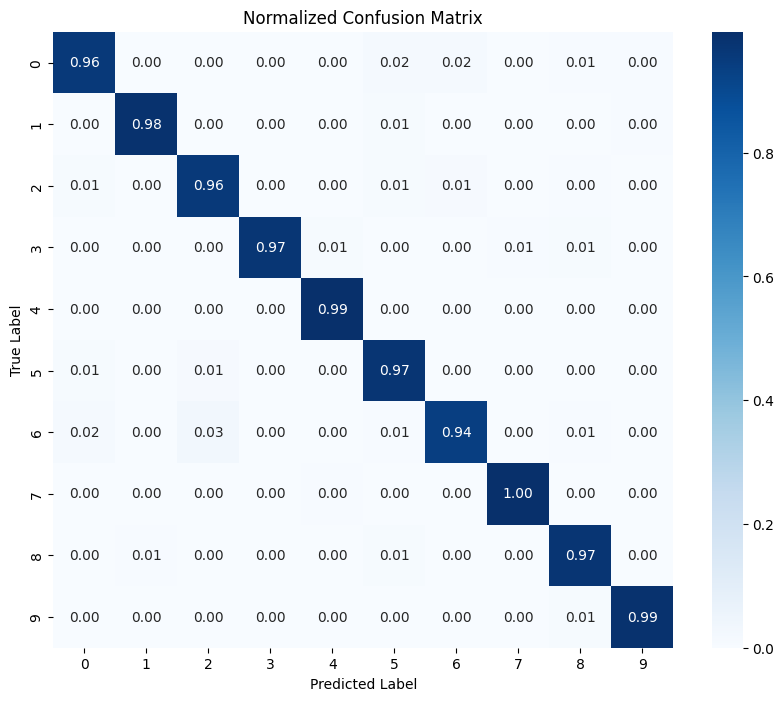

In [63]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

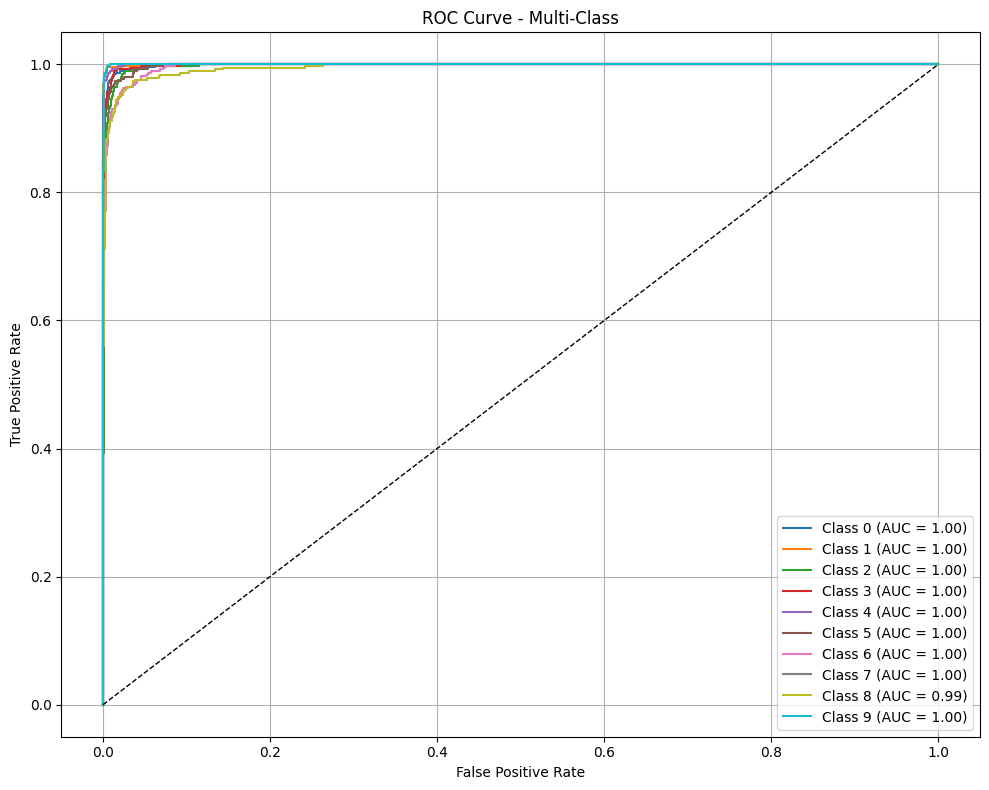

In [64]:
# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(total_class)))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()